In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from numpy import concatenate
from pandas import DataFrame
from pandas import concat

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print(tf.__version__)

Couldn't import dot_parser, loading of dot files will not be possible.
2.2.0


Using TensorFlow backend.


In [2]:
df=pd.read_csv("data_sin_tipocambio.csv")
df.head()

,date,dow(USD),euro_stoxx50(USD),nasdaq(USD),nikkei(USD),oro(USD),petroleo(USD),shangai_stock_exchange(USD),sp_500(USD),BCHAIN-TOTBC,BCHAIN-AVBLS,BCHAIN-MIREV (USD),BCHAIN-HRATE,BCHAIN-NTRBL,BCHAIN-NADDU,BCHAIN-MKPRU (USD)
0,2015-01-15,43.80,3112.370,45.670,16872.95,1380.00,48.60,4.12,2013.750,13727150.0,0.413363,761422.01,303832.201585,824.0,212403.0,218.11
1,2015-01-16,43.26,3147.530,45.730,16812.96,1404.90,46.35,4.12,1992.250,13730725.0,0.382308,768009.00,325690.633354,731.0,219873.0,205.35
2,2015-01-17,43.26,3147.530,45.730,16812.96,1342.95,47.65,4.12,1992.250,13734300.0,0.366155,677501.44,299460.515231,633.0,254267.0,197.12
3,2015-01-18,43.26,3178.075,45.730,16906.87,1281.00,48.95,4.12,1992.250,13738025.0,0.330078,789179.66,325690.633354,703.0,223392.0,211.18
4,2015-01-19,44.13,3208.620,46.165,17000.78,1279.40,48.84,4.12,2006.505,13741900.0,0.343386,826197.10,338805.692415,740.0,197559.0,212.39


In [3]:
df.shape

(2177, 16)

## Graficamos el historial del bitcoin desde el 2018 hasta la fecha

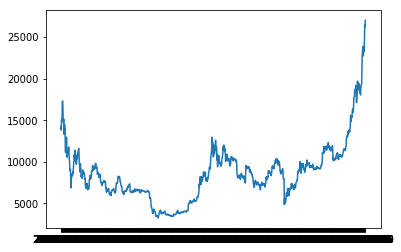

In [4]:
plt.plot(df.iloc[1082:,0], df.iloc[1082:,-1])

## Funcion para obtener ventanas a partir del dataframe (hay que pensar si nos lo rapiñamos o solo decimos de donde lo sacamos)

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        # shift
        # se utiliza para desplazar el índice de DataFrame por un número 
        # determinado de períodos con una frecuencia de tiempo opcional
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Definimos los  hiperparemetros y estandarizamos nuestros datos

In [6]:
ventana=3 # Se puede mover 
n_cols = df.shape[1] - 1 # Numero de variables incluyendo la variable objetivo
entrenamiento=800 #Cuantos dias de entrenamiento (restante sera para el conjunto test)
n_obs=ventana*n_cols

In [7]:

values = df.iloc[1082:,1:].values# Desde el primer dia del 2018

transformer = StandardScaler()
transformer.fit(values)

transformer_y = StandardScaler()
transformer_y.fit(df.iloc[1082:,-1].values.reshape(-1,1))

values = transformer.transform(values)
data = series_to_supervised(values, ventana,1 )

### Visualizamos el data frame de ventanas

In [8]:
data.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t)
3,1.161484,0.866946,-1.378602,0.528529,-1.038526,0.499388,0.477602,-0.718423,-1.813396,-0.066545,...,0.872874,0.035328,-0.974776,-1.802392,0.077947,4.423236,-1.540261,1.341660,3.707375,1.820202
4,1.161484,1.061030,-1.266617,0.672790,-0.380414,0.849897,0.860906,-0.496031,-1.809849,-0.034426,...,1.145881,-0.230036,-1.099826,-1.798572,0.079569,4.932414,-1.512628,1.359982,4.799380,1.861608
5,1.161484,0.275754,-1.222589,-0.219471,-0.565139,0.599867,0.035328,-0.849727,-1.805961,-0.044657,...,1.029824,-0.495401,-0.837567,-1.795321,0.088724,4.765112,-1.575431,1.045032,3.249554,2.421299
6,1.161484,0.500245,-0.998939,-0.040272,-0.564194,0.872874,0.035328,-0.974776,-1.802392,0.077947,...,1.082790,-0.672310,-0.658553,-1.791501,0.022579,5.696160,-1.512628,0.429209,3.256040,2.462417
7,1.161484,0.724736,-0.775289,0.138927,-0.563249,1.145881,-0.230036,-1.099826,-1.798572,0.079569,...,1.135755,-0.849220,-0.479539,-1.787818,-0.012308,5.159285,-1.527701,0.752450,3.450862,2.273169


### Creamos nuestro conjunto train y test con sus respectivos X y Y variables

In [9]:
train=data.iloc[:entrenamiento,:]
test =data.iloc[entrenamiento:,:]

train_X, train_y = train.iloc[:, :n_obs].values, train.iloc[:, -1].values
test_X, test_y = test.iloc[:, :n_obs].values, test.iloc[:, -1].values

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(800, 45) (800,)
(292, 45) (292,)


### Modificamos las dimensiones del train y test para que tengan un formato:
(muestras, ventana, numero de variables)

In [10]:
train_X = train_X.reshape((train_X.shape[0], ventana, n_cols))
test_X = test_X.reshape((test_X.shape[0], ventana, n_cols))

## Creacion del modelo

In [11]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
   tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                       strides=1, padding="causal",
                       activation="relu",
                       input_shape=[train_X.shape[1],train_X.shape[2]]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(50,activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])


model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),metrics=["mae"])
history = model.fit(train_X,train_y,shuffle=False,validation_data=(test_X,test_y),epochs=1000)

Epoch 1/1000
25/25 [==============================] - 2s 67ms/step - loss: 0.2785 - mae: 0.6058 - val_loss: 0.9168 - val_mae: 1.3501
Epoch 2/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2795 - mae: 0.6086 - val_loss: 0.9148 - val_mae: 1.3479
Epoch 3/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.2825 - mae: 0.6126 - val_loss: 0.9127 - val_mae: 1.3456
Epoch 4/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2749 - mae: 0.5954 - val_loss: 0.9106 - val_mae: 1.3433
Epoch 5/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2821 - mae: 0.6138 - val_loss: 0.9086 - val_mae: 1.3411
Epoch 6/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2720 - mae: 0.6008 - val_loss: 0.9065 - val_mae: 1.3388
Epoch 7/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2743 - mae: 0.5982 - val_loss: 0.9045 - val_mae: 1.3367
Epoch 8/1000
25/25 [==============================] - 0s 7ms/step - loss: 0

25/25 [==============================] - 0s 8ms/step - loss: 0.2084 - mae: 0.5016 - val_loss: 0.8122 - val_mae: 1.2353
Epoch 63/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.2091 - mae: 0.5034 - val_loss: 0.8108 - val_mae: 1.2337
Epoch 64/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.2081 - mae: 0.5001 - val_loss: 0.8094 - val_mae: 1.2321
Epoch 65/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.2113 - mae: 0.5102 - val_loss: 0.8080 - val_mae: 1.2307
Epoch 66/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.2065 - mae: 0.4993 - val_loss: 0.8066 - val_mae: 1.2291
Epoch 67/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.2075 - mae: 0.5027 - val_loss: 0.8052 - val_mae: 1.2275
Epoch 68/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.2109 - mae: 0.5038 - val_loss: 0.8038 - val_mae: 1.2259
Epoch 69/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.2037 -

25/25 [==============================] - 0s 9ms/step - loss: 0.1746 - mae: 0.4552 - val_loss: 0.7371 - val_mae: 1.1506
Epoch 124/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1722 - mae: 0.4448 - val_loss: 0.7360 - val_mae: 1.1493
Epoch 125/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1653 - mae: 0.4401 - val_loss: 0.7349 - val_mae: 1.1480
Epoch 126/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1717 - mae: 0.4530 - val_loss: 0.7338 - val_mae: 1.1467
Epoch 127/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1664 - mae: 0.4378 - val_loss: 0.7327 - val_mae: 1.1455
Epoch 128/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1685 - mae: 0.4406 - val_loss: 0.7317 - val_mae: 1.1443
Epoch 129/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1692 - mae: 0.4440 - val_loss: 0.7308 - val_mae: 1.1432
Epoch 130/1000
25/25 [==============================] - 0s 8ms/step - loss: 0

25/25 [==============================] - 0s 7ms/step - loss: 0.1402 - mae: 0.4017 - val_loss: 0.6770 - val_mae: 1.0799
Epoch 185/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.1381 - mae: 0.3945 - val_loss: 0.6760 - val_mae: 1.0787
Epoch 186/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1374 - mae: 0.3931 - val_loss: 0.6752 - val_mae: 1.0777
Epoch 187/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1382 - mae: 0.3934 - val_loss: 0.6742 - val_mae: 1.0765
Epoch 188/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1334 - mae: 0.3911 - val_loss: 0.6733 - val_mae: 1.0755
Epoch 189/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1367 - mae: 0.3941 - val_loss: 0.6725 - val_mae: 1.0744
Epoch 190/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1383 - mae: 0.3977 - val_loss: 0.6716 - val_mae: 1.0733
Epoch 191/1000
25/25 [==============================] - 0s 9ms/step - loss: 

25/25 [==============================] - 0s 10ms/step - loss: 0.1191 - mae: 0.3618 - val_loss: 0.6253 - val_mae: 1.0165
Epoch 246/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.1130 - mae: 0.3539 - val_loss: 0.6245 - val_mae: 1.0155
Epoch 247/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.1133 - mae: 0.3546 - val_loss: 0.6236 - val_mae: 1.0144
Epoch 248/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1138 - mae: 0.3545 - val_loss: 0.6229 - val_mae: 1.0134
Epoch 249/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1105 - mae: 0.3504 - val_loss: 0.6220 - val_mae: 1.0123
Epoch 250/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1132 - mae: 0.3530 - val_loss: 0.6213 - val_mae: 1.0114
Epoch 251/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1110 - mae: 0.3540 - val_loss: 0.6205 - val_mae: 1.0104
Epoch 252/1000
25/25 [==============================] - 0s 10ms/step - los

25/25 [==============================] - 0s 13ms/step - loss: 0.0948 - mae: 0.3183 - val_loss: 0.5778 - val_mae: 0.9553
Epoch 307/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0930 - mae: 0.3168 - val_loss: 0.5771 - val_mae: 0.9545
Epoch 308/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0951 - mae: 0.3250 - val_loss: 0.5764 - val_mae: 0.9535
Epoch 309/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0929 - mae: 0.3187 - val_loss: 0.5756 - val_mae: 0.9525
Epoch 310/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0917 - mae: 0.3201 - val_loss: 0.5748 - val_mae: 0.9514
Epoch 311/1000
25/25 [==============================] - 1s 23ms/step - loss: 0.0923 - mae: 0.3177 - val_loss: 0.5741 - val_mae: 0.9504
Epoch 312/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0961 - mae: 0.3240 - val_loss: 0.5734 - val_mae: 0.9496
Epoch 313/1000
25/25 [==============================] - 0s 13ms/step -

Epoch 367/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.0748 - mae: 0.2866 - val_loss: 0.5335 - val_mae: 0.8965
Epoch 368/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0742 - mae: 0.2832 - val_loss: 0.5328 - val_mae: 0.8955
Epoch 369/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0739 - mae: 0.2824 - val_loss: 0.5320 - val_mae: 0.8943
Epoch 370/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0766 - mae: 0.2907 - val_loss: 0.5314 - val_mae: 0.8934
Epoch 371/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0773 - mae: 0.2852 - val_loss: 0.5308 - val_mae: 0.8926
Epoch 372/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0725 - mae: 0.2798 - val_loss: 0.5302 - val_mae: 0.8918
Epoch 373/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0738 - mae: 0.2833 - val_loss: 0.5295 - val_mae: 0.8909
Epoch 374/1000
25/25 [==============================] - 

Epoch 428/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0647 - mae: 0.2602 - val_loss: 0.4946 - val_mae: 0.8430
Epoch 429/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0666 - mae: 0.2653 - val_loss: 0.4938 - val_mae: 0.8419
Epoch 430/1000
25/25 [==============================] - 0s 15ms/step - loss: 0.0627 - mae: 0.2634 - val_loss: 0.4931 - val_mae: 0.8409
Epoch 431/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0652 - mae: 0.2622 - val_loss: 0.4926 - val_mae: 0.8402
Epoch 432/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0639 - mae: 0.2592 - val_loss: 0.4920 - val_mae: 0.8394
Epoch 433/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0624 - mae: 0.2611 - val_loss: 0.4913 - val_mae: 0.8383
Epoch 434/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0618 - mae: 0.2562 - val_loss: 0.4907 - val_mae: 0.8375
Epoch 435/1000
25/25 [==============================] -

Epoch 489/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0528 - mae: 0.2442 - val_loss: 0.4603 - val_mae: 0.7956
Epoch 490/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0571 - mae: 0.2487 - val_loss: 0.4599 - val_mae: 0.7951
Epoch 491/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0543 - mae: 0.2422 - val_loss: 0.4595 - val_mae: 0.7945
Epoch 492/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0515 - mae: 0.2397 - val_loss: 0.4591 - val_mae: 0.7940
Epoch 493/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0541 - mae: 0.2447 - val_loss: 0.4586 - val_mae: 0.7933
Epoch 494/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0528 - mae: 0.2406 - val_loss: 0.4581 - val_mae: 0.7927
Epoch 495/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0525 - mae: 0.2379 - val_loss: 0.4576 - val_mae: 0.7919
Epoch 496/1000
25/25 [==============================] -

Epoch 550/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0455 - mae: 0.2219 - val_loss: 0.4328 - val_mae: 0.7586
Epoch 551/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0440 - mae: 0.2199 - val_loss: 0.4325 - val_mae: 0.7582
Epoch 552/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0457 - mae: 0.2234 - val_loss: 0.4321 - val_mae: 0.7577
Epoch 553/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0457 - mae: 0.2301 - val_loss: 0.4315 - val_mae: 0.7568
Epoch 554/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0465 - mae: 0.2271 - val_loss: 0.4310 - val_mae: 0.7562
Epoch 555/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0443 - mae: 0.2233 - val_loss: 0.4305 - val_mae: 0.7555
Epoch 556/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0470 - mae: 0.2253 - val_loss: 0.4302 - val_mae: 0.7551
Epoch 557/1000
25/25 [==============================] -

Epoch 611/1000
25/25 [==============================] - 0s 15ms/step - loss: 0.0380 - mae: 0.2108 - val_loss: 0.4106 - val_mae: 0.7294
Epoch 612/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.0427 - mae: 0.2200 - val_loss: 0.4104 - val_mae: 0.7292
Epoch 613/1000
25/25 [==============================] - 0s 15ms/step - loss: 0.0379 - mae: 0.2046 - val_loss: 0.4101 - val_mae: 0.7287
Epoch 614/1000
25/25 [==============================] - 0s 15ms/step - loss: 0.0396 - mae: 0.2126 - val_loss: 0.4097 - val_mae: 0.7283
Epoch 615/1000
25/25 [==============================] - 0s 15ms/step - loss: 0.0377 - mae: 0.2074 - val_loss: 0.4094 - val_mae: 0.7279
Epoch 616/1000
25/25 [==============================] - 0s 15ms/step - loss: 0.0389 - mae: 0.2136 - val_loss: 0.4090 - val_mae: 0.7273
Epoch 617/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0382 - mae: 0.2105 - val_loss: 0.4089 - val_mae: 0.7273
Epoch 618/1000
25/25 [==============================] -

Epoch 672/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.0357 - mae: 0.2048 - val_loss: 0.3944 - val_mae: 0.7102
Epoch 673/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.0369 - mae: 0.2047 - val_loss: 0.3943 - val_mae: 0.7101
Epoch 674/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0351 - mae: 0.2009 - val_loss: 0.3941 - val_mae: 0.7099
Epoch 675/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0365 - mae: 0.2062 - val_loss: 0.3938 - val_mae: 0.7096
Epoch 676/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0361 - mae: 0.2031 - val_loss: 0.3935 - val_mae: 0.7092
Epoch 677/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0321 - mae: 0.1916 - val_loss: 0.3932 - val_mae: 0.7087
Epoch 678/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0343 - mae: 0.2017 - val_loss: 0.3929 - val_mae: 0.7083
Epoch 679/1000
25/25 [==============================] - 0s

Epoch 733/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0333 - mae: 0.1937 - val_loss: 0.3808 - val_mae: 0.6944
Epoch 734/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0333 - mae: 0.1974 - val_loss: 0.3806 - val_mae: 0.6941
Epoch 735/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0320 - mae: 0.1942 - val_loss: 0.3804 - val_mae: 0.6939
Epoch 736/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.0334 - mae: 0.1965 - val_loss: 0.3802 - val_mae: 0.6937
Epoch 737/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0341 - mae: 0.1995 - val_loss: 0.3801 - val_mae: 0.6937
Epoch 738/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0336 - mae: 0.2011 - val_loss: 0.3801 - val_mae: 0.6937
Epoch 739/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0326 - mae: 0.1950 - val_loss: 0.3800 - val_mae: 0.6936
Epoch 740/1000
25/25 [==============================] - 0

Epoch 794/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0294 - mae: 0.1832 - val_loss: 0.3717 - val_mae: 0.6851
Epoch 795/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0304 - mae: 0.1892 - val_loss: 0.3716 - val_mae: 0.6849
Epoch 796/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.0296 - mae: 0.1864 - val_loss: 0.3714 - val_mae: 0.6847
Epoch 797/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0288 - mae: 0.1868 - val_loss: 0.3712 - val_mae: 0.6844
Epoch 798/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0287 - mae: 0.1834 - val_loss: 0.3712 - val_mae: 0.6844
Epoch 799/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0307 - mae: 0.1877 - val_loss: 0.3712 - val_mae: 0.6846
Epoch 800/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0286 - mae: 0.1799 - val_loss: 0.3710 - val_mae: 0.6842
Epoch 801/1000
25/25 [==============================] - 

Epoch 855/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.0272 - mae: 0.1793 - val_loss: 0.3642 - val_mae: 0.6775
Epoch 856/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0265 - mae: 0.1790 - val_loss: 0.3643 - val_mae: 0.6776
Epoch 857/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0257 - mae: 0.1747 - val_loss: 0.3643 - val_mae: 0.6778
Epoch 858/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.0272 - mae: 0.1782 - val_loss: 0.3645 - val_mae: 0.6781
Epoch 859/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.0278 - mae: 0.1808 - val_loss: 0.3643 - val_mae: 0.6778
Epoch 860/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0275 - mae: 0.1798 - val_loss: 0.3640 - val_mae: 0.6775
Epoch 861/1000
25/25 [==============================] - 0s 15ms/step - loss: 0.0287 - mae: 0.1830 - val_loss: 0.3639 - val_mae: 0.6774
Epoch 862/1000
25/25 [==============================] - 

Epoch 916/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0256 - mae: 0.1731 - val_loss: 0.3582 - val_mae: 0.6718
Epoch 917/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0266 - mae: 0.1772 - val_loss: 0.3582 - val_mae: 0.6717
Epoch 918/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0250 - mae: 0.1691 - val_loss: 0.3582 - val_mae: 0.6718
Epoch 919/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.0263 - mae: 0.1755 - val_loss: 0.3580 - val_mae: 0.6715
Epoch 920/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0269 - mae: 0.1753 - val_loss: 0.3578 - val_mae: 0.6713
Epoch 921/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.0267 - mae: 0.1790 - val_loss: 0.3575 - val_mae: 0.6710
Epoch 922/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.0267 - mae: 0.1748 - val_loss: 0.3575 - val_mae: 0.6710
Epoch 923/1000
25/25 [==============================] - 0s

Epoch 977/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0277 - mae: 0.1780 - val_loss: 0.3525 - val_mae: 0.6663
Epoch 978/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0245 - mae: 0.1681 - val_loss: 0.3524 - val_mae: 0.6662
Epoch 979/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0252 - mae: 0.1732 - val_loss: 0.3525 - val_mae: 0.6664
Epoch 980/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0251 - mae: 0.1701 - val_loss: 0.3525 - val_mae: 0.6664
Epoch 981/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0240 - mae: 0.1707 - val_loss: 0.3524 - val_mae: 0.6663
Epoch 982/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0226 - mae: 0.1631 - val_loss: 0.3522 - val_mae: 0.6661
Epoch 983/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0265 - mae: 0.1767 - val_loss: 0.3520 - val_mae: 0.6657
Epoch 984/1000
25/25 [==============================] -

## Graficamos la funcion de perdida del trainning vs el test

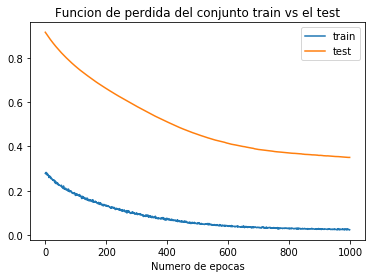

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Funcion de perdida del conjunto train vs el test")
plt.xlabel("Numero de epocas")
plt.show()


### Predecimos el test y lo graficamos con respecto al valor real

In [13]:
y_pred=model.predict(test_X)
y_pred_inv=transformer_y.inverse_transform(y_pred)# Transformamos a la escala real de los datos

Text(0.5,0,'Numero de dias')

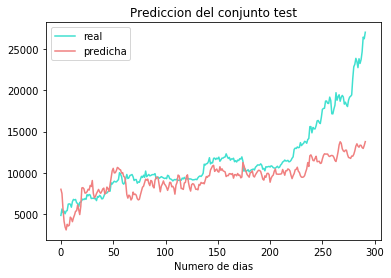

In [14]:
plt.plot(range(0,len(test_X)),df.iloc[-len(test_X):,-1],color="turquoise",label="real")
plt.plot(range(0,len(test_X)),y_pred_inv, color="lightcoral",label="predicha")
plt.legend()
plt.title("Prediccion del conjunto test")
plt.xlabel("Numero de dias")

### Predecimos el train y lo graficamos con respecto al valor real

In [15]:
y_pred_t=model.predict(train_X)
y_pred_inv_t=transformer_y.inverse_transform(y_pred_t)# Transformamos a la escala real de los datos

Text(0.5,0,'Numero de dias')

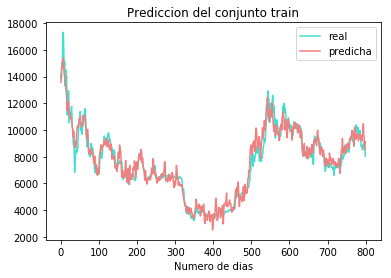

In [16]:
plt.plot(range(0,len(train_X)),df.iloc[1082:1082+len(train_X),-1],color="turquoise",label="real")
plt.plot(range(0,len(train_X)),y_pred_inv_t, color="lightcoral",label="predicha")
plt.legend()
plt.title("Prediccion del conjunto train")
plt.xlabel("Numero de dias")

In [17]:
 #model.save('modelo_3-norm.h5')

In [18]:
#model=load_model("modelo_3-norm.h5")

In [19]:
# loss: 0.0235 - mae: 0.1674 - val_loss: 0.3506 - val_mae: 0.6643
# ventana: 3
# epocas: 1000
# tasa: 1e-6
# lambda: 10.0
# Dropout: 0.2
# entrenamiento: 800
# df: data_sin_tipocambio
#model.save('modelo_4-norm.h5')